# Concept Vectors (CVs) Demo Notebook

This notebook will help you go through the most important insights from the __[Concept Vectors paper](https://arxiv.org/abs/2503.03666)__.

Note that the aim of notebook is not to go through every low-level implementation in detail, but rather to point you to the most relevant parts in this repository.

## Preliminaries

### Required packages

Installing all the packages using pip.

In [3]:
%pip install -q -r ../requirements.txt
# %pip install -q nnsight # uncomment this line to install the latest nnsight version

Note: you may need to restart the kernel to use updated packages.


### NNsight
The models in this notebook run on the remote __[NDIF](https://ndif.us/)__ server.

This requires you to have an NNsight API key. You can apply for a free API key __[here](https://login.ndif.us/)__ and set it below.

If you get server errors when running the models, it might mean you need to install the latest version of nnsight. You can do that in the cell above.

In [2]:
import nnsight
import os

os.environ['NNSIGHT_API_KEY'] = 'YOUR_API_KEY'

if not nnsight.CONFIG.API.APIKEY:
    nnsight.CONFIG.set_default_api_key(os.environ['NNSIGHT_API_KEY'])

/Users/gustaw/Documents/concept_vectors/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LLama 3.1 70B

Llama3.1 70b is a gated model and you need access via your huggingface token. You can get one  __[here](https://huggingface.co/meta-llama/Llama-3.1-70B)__.


In [2]:
os.environ['HF_TOKEN'] = "YOUR_HUGGING_FACE_TOKEN"

### Imports

In [3]:
import sys
sys.path.append('..')

import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.utils.ICL_utils import ICLDataset, DatasetConstructor
from src.utils.model_utils import ExtendedLanguageModel
from src.utils.query_utils import get_summed_vec_per_item, compute_similarity_matrix, get_avg_summed_vec, intervene_with_vec, get_completions
from src.utils.eval_utils import SimilarityMatrix, accuracy_completions

## Extracting and Visualising CVs

In this section we will extract CVs from a sample of prompts used in the paper and visualise them.

We will use the LLama-3.1-70B model.

We will make use of the <code>ExtendedLanguageModel</code> class which is a wrapper around NNsight's <code>LanguageModel</code>. You can set the number of heads you will construct your CV from in the <code>cv_heads_n</code> argument. It defaults to 3 as in the paper.

In [4]:
model = ExtendedLanguageModel(model_name='meta-llama/Meta-LLama-3.1-70B', cv_heads_n=3)

We will test our CVs on in-context-learning (ICL) tasks coming from two concepts: 

**antonym** and **categorization** 

Each of them is represented in three low-level formats: 
1. Open-Ended in English
2. Open-Ended in a different language (French/Spanish)
3. Multiple-Choice in English

We will create **20** ICL prompts( **5-shot**) per concept and low-level format (120 in total).

In [5]:
datasets = [
    'antonym_eng', 
    'antonym_fr', 
    'antonym_eng-mc', 
    'categorical_eng', 
    'categorical_es', 
    'categorical_eng-mc'
]

# DatasetConstructor class is quite project-specific so we won't go into details 
dataset = DatasetConstructor(
    dataset_ids=datasets,
    dataset_size=20, 
    # We set the batch size equal to the dataset size (20) because prompt lengths vary considerably.
    # Multi-choice prompts are notably longer than open-choice ones, leading to excess padding in shorter prompts,
    # which can unexpectedly affect the model's internals.
    batch_size=20,
    n_train=5,
    seed=100
)

Let's print some of the items. The cyan colored part of the prompt is the model's expected completion.

In [5]:
dataset.datasets[0].pretty_print_item(item=0)
dataset.datasets[-1].pretty_print_item()

antonym_eng

Q: good
A: bad

Q: real
A: fake

Q: meaningful
A: meaningless

Q: irrelevant
A: relevant

Q: immediate
A: delayed

Q: jerk
A: gentleman

categorical_eng-mc

### Instruction: Q: pink A: 

(a) grain
(b) color
(c) music
(d) bird

### Response: (b)

### Instruction: Q: cobra A: 

(a) snake
(b) fish
(c) fruit
(d) dairy

### Response: (a)

### Instruction: Q: refrigerator A: 

(a) animal
(b) machine
(c) vegetation
(d) place

### Response: (b)

### Instruction: Q: frisbee A: 

(a) toy
(b) fabric
(c) gadget
(d) weapon

### Response: (a)

### Instruction: Q: mango A: 

(a) appliance
(b) toiletry
(c) ocean
(d) fruit

### Response: (d)

### Instruction: Q: albatross A: 

(a) religion
(b) bird
(c) disease
(d) science

### Response: (b

Let's extract the CVs! <code>get_summed_vec_per_item</code> extracts outputs from each a list of attention heads and takes their sum per item (i.e. returing a single vector per prompt). We pass in the heads comprising in the CV, stored in <code>model.cv_heads</code>.

Running this cell should take < 30 seconds.

In [6]:
cv_vecs = get_summed_vec_per_item(model=model, dataset=dataset, heads=model.cv_heads)

2025-03-27 17:28:04,237 8d887778-dc04-4dd0-bfc8-611edda7e879 - RECEIVED: Your job has been received and is waiting approval.
2025-03-27 17:28:04,574 8d887778-dc04-4dd0-bfc8-611edda7e879 - APPROVED: Your job was approved and is waiting to be run.
2025-03-27 17:28:05,046 8d887778-dc04-4dd0-bfc8-611edda7e879 - RUNNING: Your job has started running.
2025-03-27 17:28:09,459 8d887778-dc04-4dd0-bfc8-611edda7e879 - COMPLETED: Your job has been completed.


If NDIF is down or it doesn't work for you for any other reason you can load the vectors here.

In [6]:
cv_vecs = pickle.load(open('data/cvs.pkl', 'rb'))

We see that we now have 120 vectors each of dimensionality of 8192 (corresponding to the size of LLama 70B's residual stream).

In [7]:
cv_vecs.shape

torch.Size([120, 8192])

Let's construct a pairwise similarity matrix for our CVs. <code>compute_similarity_matrix</code> computes cosine similarity for each pair of vectors. As you can the similarity matrix is a square matrix a shape of 120x120 (corresponding to our number of prompts).

In [8]:
cv_simmat = compute_similarity_matrix(cv_vecs).numpy()
cv_simmat.shape

(120, 120)

Let's visualise the similarity matrix! <code>SimilarityMatrix</code> is a generalized helper class to visualise similarity matrices. Throughout the notebook we will demonstrate its most useful properties.

We see that the CVs cluster nicely within the concepts.

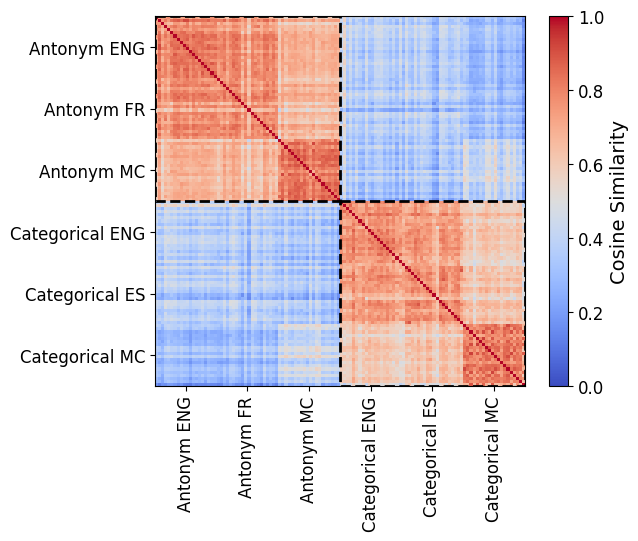

In [9]:
# The names of the individual tasks
tasks = ['Antonym ENG', 'Antonym FR', 'Antonym MC', 'Categorical ENG', 'Categorical ES', 'Categorical MC']
# The names of the concepts that the tasks are based on. This will allow us to draw bounding boxes around the concepts
concepts = ['antonym', 'antonym', 'antonym', 'categorical', 'categorical', 'categorical']

simmat = SimilarityMatrix(
    sim_mat=cv_simmat,
    tasks=tasks,
    attribute_list=concepts
)

simmat.plot(bounding_boxes=True)

We can also relocate the tasks to present the similarity matrix in a different way using the <code>relocate_tasks</code> method. Here we alternate between the concepts. We also modify the plot so that we only show the lower diagonal and plot the mean cosine similairy values for each pair of task. This is more for illustrative purposes, as I found this feature of <code>SimilarityMatrix</code> useful in the experimentation phase. This example does not bear much meaningful insights apart from creating a pretty mosaic.

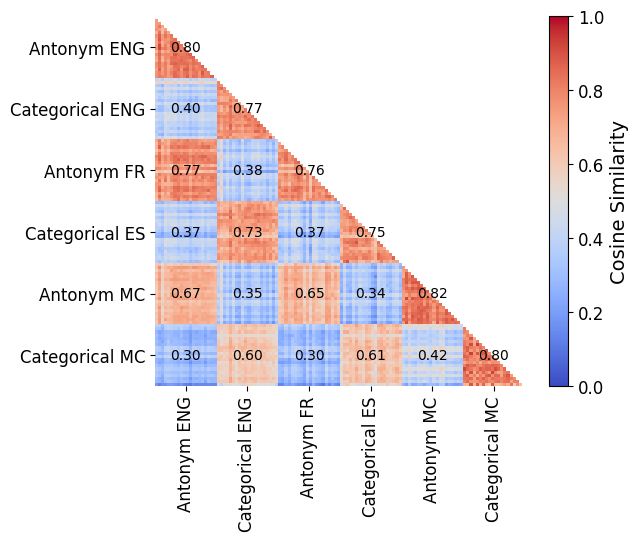

In [10]:
simmat.relocate_tasks([
    'Antonym ENG',
    'Categorical ENG',
    'Antonym FR',
    'Categorical ES',
    'Antonym MC',
    'Categorical MC'
])
simmat.plot(plot_means=True, plot_lower_diag=True)

### Adding CVs of Abstract Concepts

We will now showcase the tasks representing our abstract concepts *next* and *previous*.

Each of concepts is represented in three low-level formats: 
1. Items in ordered list - made up of known ordered lists (e.g., days, months, letters, numbers).
2. Abstract Letter - tasks representing next/previous more abstractly with letters
3. Abstract Words - Tasks representing next/previous more abstractly with words

We create the items here. The <code>seq_len</code> argument controls the token length of the abstract sequences. See some examples below:

In [11]:
dataset_abstract = DatasetConstructor(
    dataset_ids=['prev_item', 'predecessor_letter', 'predecessor_word', 'next_item', 'successor_letter', 'successor_word'],
    seq_len=20,
    dataset_size=20,
    batch_size=20,
    n_train=5,
    tokenizer=model.lm.tokenizer,
    seed=89
)

for i in [0, 1, 5]:
    dataset_abstract.datasets[i].pretty_print_item()

prev_item

Q: november
A: october

Q: f
A: e

Q: Y
A: X

Q: QQ
A: PP

Q: l
A: k

Q: 17
A: 16

predecessor_letter

Q: a . . . . . . . . . d . . . . c . b * .
A: b

Q: . . . d . * . c . . b . . . . . a . . .
A: d

Q: . . . . . . c . . . * d . . b . a . . .
A: c

Q: . a . d . . . c . * . . . . . . . b . .
A: c

Q: . . . b . . a d . . * . . . c . . . . .
A: d

Q: . . . . . . . d * . . . a c . b . . . .
A: d

successor_word

Q: . . . . . . fake . . . . popular . recall . . * hard . .
A: hard

Q: . * samples . . . . . . . which . hip . . escaped . . . .
A: samples

Q: . * . . bench . query . . . western . . . range . . . . .
A: bench

Q: * porter . . landscape . . . . theory . . . . . . . deliver . .
A: porter

Q: finite . . . . search . . . references . . * . . . . wish . .
A: wish

Q: . . . . . . supply . . . . . . . equipment * . chapter . brick
A: chapter

Let's extract the CVs for these items.

In [12]:
try:
    cv_vecs_abstract = get_summed_vec_per_item(model=model, dataset=dataset_abstract, heads=model.cv_heads)
except:
    print('Server run failed. Loading precomputed vectors.')
    cv_vecs_abstract = pickle.load(open('data/cvs_abstract.pkl', 'rb'))

2025-03-07 17:51:30,062 8cab2d3f-d423-4647-a632-8f281ac21af8 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 17:51:30,320 8cab2d3f-d423-4647-a632-8f281ac21af8 - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 17:51:30,878 8cab2d3f-d423-4647-a632-8f281ac21af8 - RUNNING: Your job has started running.
2025-03-07 17:51:36,099 8cab2d3f-d423-4647-a632-8f281ac21af8 - COMPLETED: Your job has been completed.


Let's concatanate them with our previous CVs and visualise the whole similarity matrix.

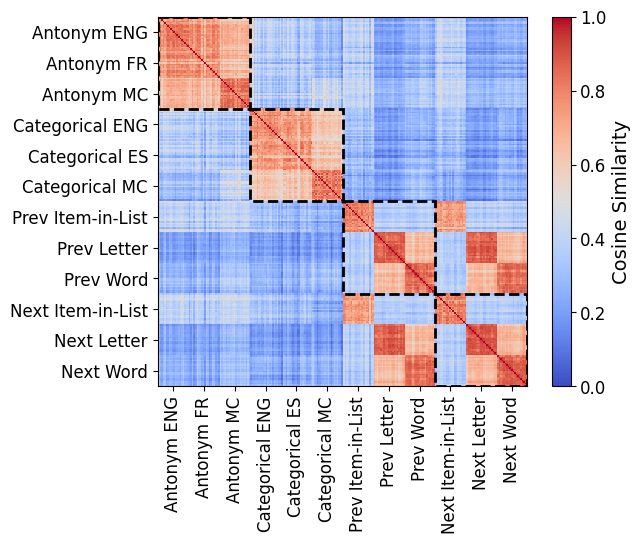

In [13]:
cv_vecs_full = torch.concat([cv_vecs, cv_vecs_abstract])
cv_simmat_full = compute_similarity_matrix(cv_vecs_full).numpy()

simmat_full = SimilarityMatrix(
    sim_mat=cv_simmat_full,
    tasks=tasks + ['Prev Item-in-List', 'Prev Letter', 'Prev Word', 'Next Item-in-List', 'Next Letter', 'Next Word'],
    attribute_list=concepts + ['previous', 'previous', 'previous', 'next', 'next', 'next']
)
simmat_full.plot(bounding_boxes=True)

One other useful method in <code>SimilarityMatrix</code> is <code>filter_tasks</code>, where all the other tasks are deleted from the object. This cannot be "undone" so once you filter tasks out, to get them back you need to redefine the similarity matrix again.

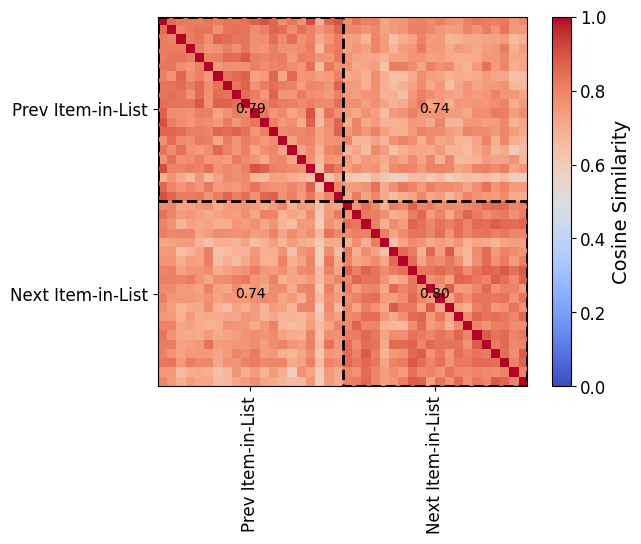

In [23]:
simmat_full.filter_tasks(['Prev Item-in-List', 'Next Item-in-List'])
simmat_full.plot(plot_means=True, bounding_boxes=True)

# Intervention

One of the properties of the CVs is that they can be pasted into model internals to guide its behaviour. We demonstrate this using *AmbigousICL* tasks where we randomly interleave two concepts in the ICL prompt, which makes it ambigous which concept to use to complete the query.

We construct 100 10-shot prompts with the concepts antonym (open-ended in English) and translation (open-ended; English to French).

In [27]:
ambigousICL = ICLDataset(
    dataset=['antonym_eng', 'english_french'],
    size=100, 
    n_train=10,
    seed=42
)
ambigousICL.pretty_print_item()

['antonym_eng', 'english_french']

Q: off
A: on

Q: ignore
A: ignorer

Q: insufficient
A: insuffisant

Q: formal
A: formel

Q: valid
A: valide

Q: magical
A: mundane

Q: novel
A: classic

Q: unaccustomed
A: inaccoutumé

Q: abnormal
A: normal

Q: most
A: least

Q: stiff
A: rigide

Q: practical
A: impractical

To intervene on the model and steer it to use the concept 'antonym' and respond **impractical** instead of the french translation **practique** we will construct a single antonym CV. To do this we crate 50 5-shot ICL antonym (open-ended in French) prompts. Using <code>get_avg_summed_vec</code> we then take the average of the attention head outputs over all prompts before summing them into a single vector. Running this cell should take < 10 seconds. 

In [32]:
dataset_extract = DatasetConstructor('antonym_fr', dataset_size=50, n_train=5, seed=42)
cv_antonym = get_avg_summed_vec(model, dataset_extract, model.cv_heads)
cv_antonym.shape # We get a single vector that matches the size of the model's residual stream

2025-03-07 15:24:24,209 a8e27feb-8543-4a4e-b848-a92e3a1c1296 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 15:24:24,657 a8e27feb-8543-4a4e-b848-a92e3a1c1296 - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 15:24:25,025 a8e27feb-8543-4a4e-b848-a92e3a1c1296 - RUNNING: Your job has started running.
2025-03-07 15:24:26,034 a8e27feb-8543-4a4e-b848-a92e3a1c1296 - COMPLETED: Your job has been completed.


torch.Size([8192])

Now using <code>intervene_with_vec</code> we run a forward pass for our prompts where we paste the CV to the model's residual stream at a specified layer. We found the optimal layer to be 31 (stored in <code>model.cv_intervention_layer</code>). We apply 10x scaling to the CV. The output of <code>intervene_with_vec</code> is a list of model completions for all prompts (first-token only). This cell should take < 10 seconds to run.

In [33]:
cv_completions = intervene_with_vec(
    model=model, 
    dataset=ambigousICL, 
    vector=cv_antonym*10, 
    layers=model.cv_intervention_layer
)
cv_completions = cv_completions[model.cv_intervention_layer] # intervene_with_vec returns a dict {layer: completions}

2025-03-07 15:24:32,369 adf744b1-ee3d-4529-b582-5f7201f6af16 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 15:24:32,667 adf744b1-ee3d-4529-b582-5f7201f6af16 - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 15:24:32,935 adf744b1-ee3d-4529-b582-5f7201f6af16 - RUNNING: Your job has started running.
2025-03-07 15:24:33,190 adf744b1-ee3d-4529-b582-5f7201f6af16 - LOG: Layer: 31
2025-03-07 15:24:37,230 adf744b1-ee3d-4529-b582-5f7201f6af16 - COMPLETED: Your job has been completed.


Let's now get the model completions without intervention using <code>get_completions</code>, so we have a baseline model accuracy. 

In [34]:
org_completions = get_completions(model, ambigousICL)

2025-03-07 15:24:40,507 603774f8-bbb9-42d0-aa53-ea04ae19ddc6 - RECEIVED: Your job has been received and is waiting approval.
2025-03-07 15:24:41,429 603774f8-bbb9-42d0-aa53-ea04ae19ddc6 - APPROVED: Your job was approved and is waiting to be run.
2025-03-07 15:24:41,695 603774f8-bbb9-42d0-aa53-ea04ae19ddc6 - RUNNING: Your job has started running.
2025-03-07 15:24:45,502 603774f8-bbb9-42d0-aa53-ea04ae19ddc6 - COMPLETED: Your job has been completed.


We calculate the accuracies between the generated and expected completions using <code>accuracy_completions</code>, which takes in the generated and expected completions as well as <code>ExtendedLanguageModel</code> object. We consider the model to get a prompt correct if the token it spits out mathces the *first* token of the expected completion (sometimes it is the entire expected completion, sometimes only a part of it). Using the tokenizer from <code>ExtendedLanguageModel</code> object we get the first token of the completion.

In [36]:
org_acc = accuracy_completions(model=model, completions=org_completions, Ys=ambigousICL.completions)
cv_acc = accuracy_completions(model=model, completions=cv_completions, Ys=ambigousICL.completions)

print(f'Original accuracy: {org_acc*100:.0f}%')
print(f'Intervened accuracy: {cv_acc*100:.0f}%')

Original accuracy: 21%
Intervened accuracy: 46%


We successfully steered Llama-3.1-70B's behavior using CVs!

# Representational Similarity Analysis

We localized the attention heads using Representational Similarity Analysis (RSA). On a high-level this allows us to quantify whether the model representations cluster due to the concepts or not.

That is, given N prompts:
1. Create a N x N binary design matrix (DM), where entries are set to 1 if two prompts share the same concept, 0 otherwise.

Then, *for each attention head* we:

2. Extract outputs to our N prompts.
3. Compute a N x N similarity matrix using cosine similarity.
4. Measure the alignment (denoted by Φconcept) by computing the correlation between lower-triangular portions of the RSM and the DM.

We demonstrate this procedure on top 10 CV attention heads. You can find an implementation scaled to all attention heads in a model in <code>src/calculate_sim_met.py</code>

In [24]:
from src.utils.eval_utils import create_design_matrix, rsa
from src.utils.query_utils import get_simmats

dataset = DatasetConstructor(
    dataset_ids=['antonym_eng', 'antonym_fr', 'antonym_eng-mc', 'categorical_eng', 'categorical_es', 'categorical_eng-mc'],
    dataset_size=20, 
    batch_size=20,
    n_train=5,
    seed=100
)

concepts = ['antonym', 'antonym', 'antonym', 'categorical', 'categorical', 'categorical']

1. Let's create the Design Matrix and visualise it!

In [25]:
concepts_list = np.repeat(concepts, 20) # repeat the concepts dataset_size times for each concept
design_matrix = create_design_matrix(concepts_list)

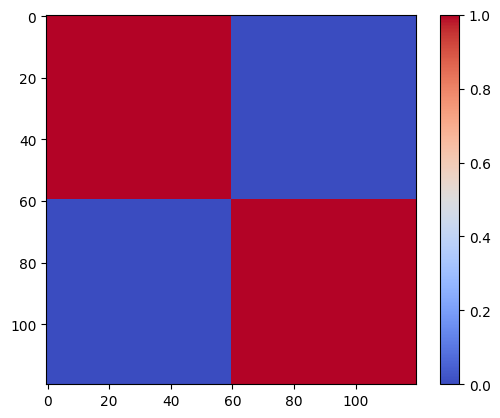

In [26]:
plt.imshow(design_matrix, cmap='coolwarm'); plt.colorbar(); plt.show()

2. and 3.

In [8]:
simmats_dict = get_simmats(model, dataset, layers=[33])

2025-03-27 15:45:08,003 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - RECEIVED: Your job has been received and is waiting approval.
2025-03-27 15:45:08,925 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - APPROVED: Your job was approved and is waiting to be run.
2025-03-27 15:45:10,100 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - RUNNING: Your job has started running.
2025-03-27 15:45:10,843 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 0
2025-03-27 15:45:11,863 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 1
2025-03-27 15:45:12,840 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 2
2025-03-27 15:45:14,360 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 3
2025-03-27 15:45:14,784 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 4
2025-03-27 15:45:15,771 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Batch: 5
2025-03-27 15:45:17,448 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - LOG: Computing similarity matrices ...
2025-03-27 15:45:34,647 2f1f3bc4-f4f1-48b3-8f41-852cb56f2836 - COMPLETED: Your job has b

In [ ]:
# Convert to numpy
simmats = np.stack([simmat.to(torch.float32).numpy() for simmat in simmats_dict.values()])
simmats.shape

(64, 120, 120)

4. 

In [11]:
rsa_per_head = []
for simmat_head in simmats:    
    rsa_val = rsa(X=simmat_head, Y=design_matrix)
    rsa_per_head.append(rsa_val)

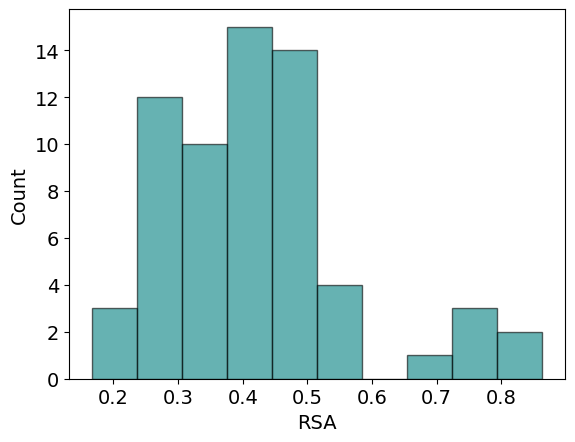

In [12]:
plt.rcParams.update({'font.size': 14})
plt.hist(rsa_per_head, color='teal', edgecolor='black', alpha=0.6, bins=10)
plt.xlabel('RSA')
plt.ylabel('Count')
plt.show()

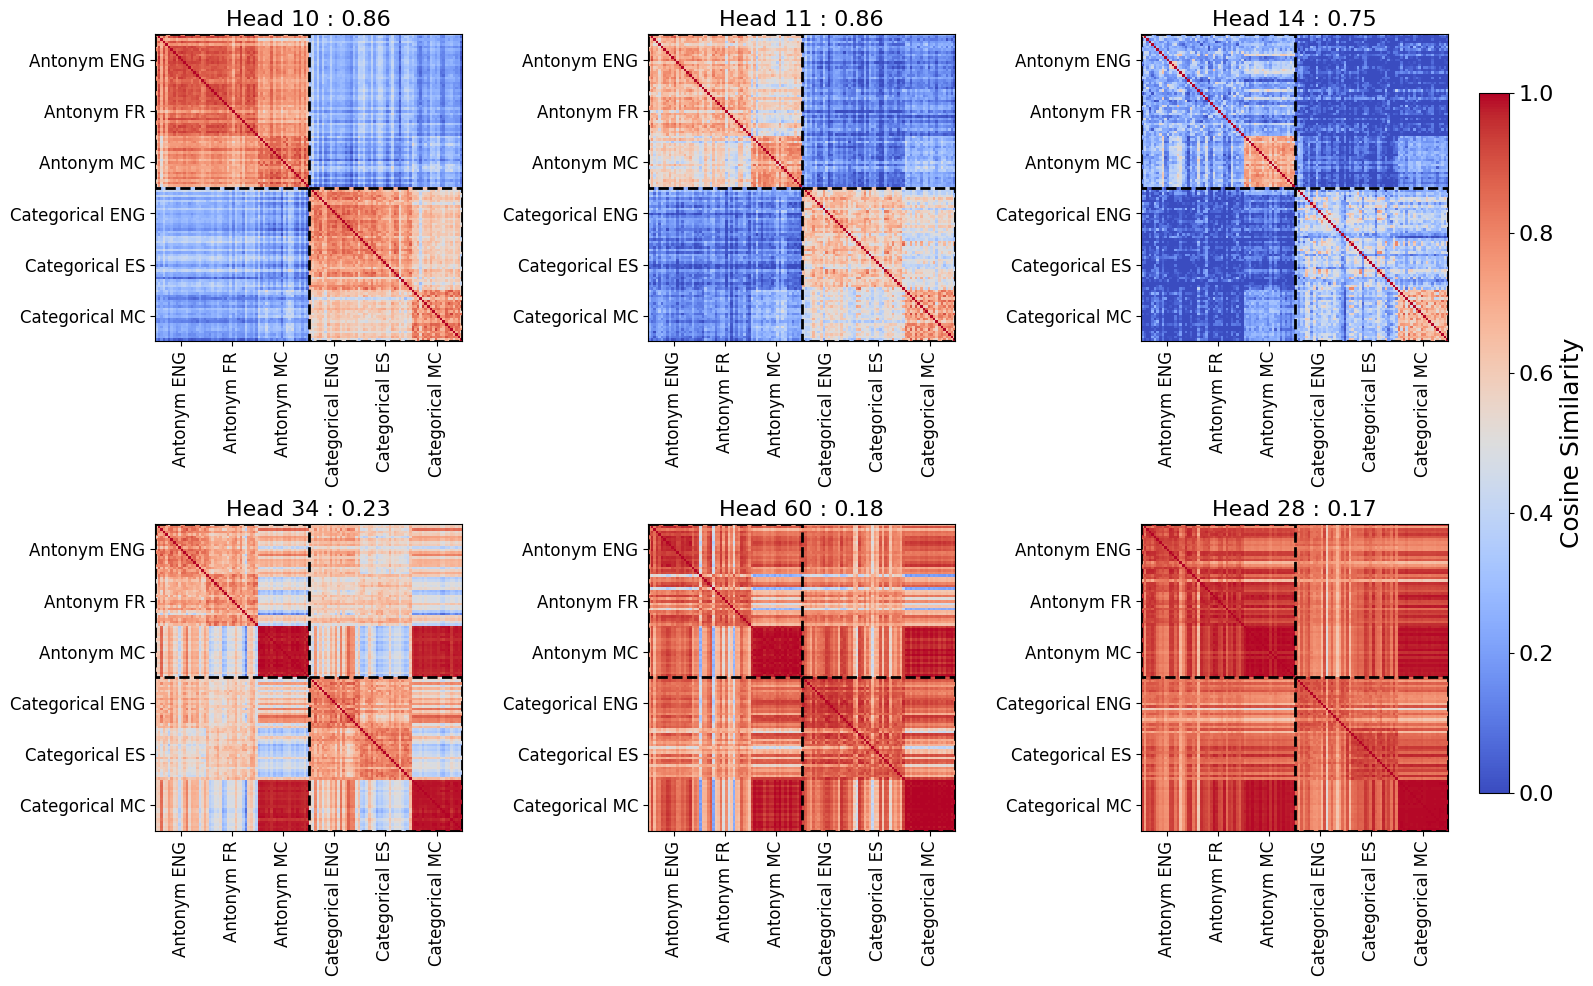

In [36]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

tasks = ['Antonym ENG', 'Antonym FR', 'Antonym MC', 'Categorical ENG', 'Categorical ES', 'Categorical MC']
concepts = ['antonym', 'antonym', 'antonym', 'categorical', 'categorical', 'categorical']

# Get the top and bottom 3 heads
top_heads = np.argsort(rsa_per_head)[-3:][::-1]
bottom_heads = np.argsort(rsa_per_head)[:3][::-1]
heads_to_plot = np.concatenate([top_heads, bottom_heads])

# Create a figure with 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Plot the similarity matrices
ax = ax.flatten()
for head_idx, head in enumerate(heads_to_plot):
    simmat = SimilarityMatrix(
        sim_mat=simmats[head],
        tasks=tasks,
        attribute_list=concepts
    )
    simmat.plot(bounding_boxes=True, axis=ax[head_idx], title=f'Head {head+1} : {rsa_per_head[head]:.2f}')

plt.tight_layout()

# Add a colorbar
cbar_ax = fig.add_axes([1, 0.2, 0.02, 0.7]) 
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap='coolwarm'), cax=cbar_ax, fraction=0.02)
cbar.set_label('Cosine Similarity', fontsize=18)
cbar.ax.tick_params(labelsize=16) 

plt.show()

# Your tasks

In [20]:
class Dataset:
    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __getitem__(self, idx):
        if idx >= len(self.x) // self.batch_size:
            raise IndexError("Index out of range")
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.x))
        return self.x[start_idx:end_idx], self.y[start_idx:end_idx]

In [21]:
x = [
    'Happy is the opposite of ',
    'Big is the antonym of ',
    'Dog is an example of an ',
    'Amsterdam is an instance of a ',
]

y = [
    'sad',
    'small',
    'animal',
    'city',
]

In [22]:
dataset = Dataset(x, y, batch_size=2)
for x, y in dataset:
    print(x, y)

['Happy is the opposite of ', 'Big is the antonym of '] ['sad', 'small']
['Dog is an example of an ', 'Amsterdam is an instance of a '] ['animal', 'city']


In [ ]:
cv_vecs = get_summed_vec_per_item(model, dataset, model.cv_heads)
cv_simmat = compute_similarity_matrix(cv_vecs).numpy()


2025-03-27 17:29:29,069 9caff4de-0648-405b-b5c8-2a79be6702a0 - RECEIVED: Your job has been received and is waiting approval.
2025-03-27 17:29:29,349 9caff4de-0648-405b-b5c8-2a79be6702a0 - APPROVED: Your job was approved and is waiting to be run.
2025-03-27 17:29:29,903 9caff4de-0648-405b-b5c8-2a79be6702a0 - RUNNING: Your job has started running.
2025-03-27 17:29:31,169 9caff4de-0648-405b-b5c8-2a79be6702a0 - COMPLETED: Your job has been completed.


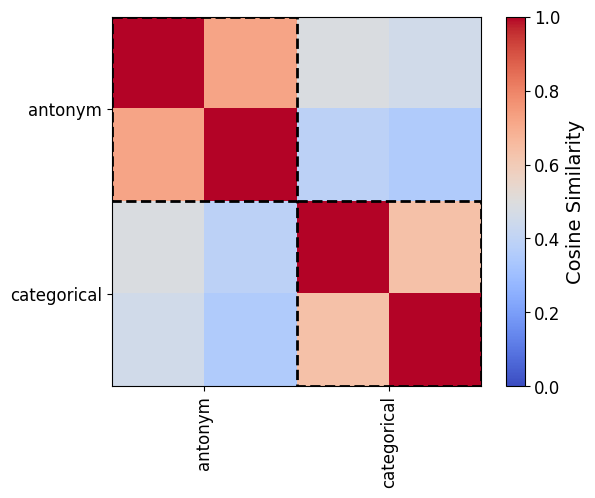

In [19]:
concepts = ['antonym', 'antonym', 'categorical', 'categorical']
SimilarityMatrix(sim_mat=cv_simmat, tasks=concepts, attribute_list=concepts).plot(bounding_boxes=True)

# Note on extracting the outputs from attention heads

Image Credit - Callum McDougall

# ![Attention Head Outputs](data/rearrange-output-ablated-2.png)
